In [64]:
import tensorflow as tf


In [65]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [66]:
# 设置TensorFlow使用单个GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU: ", gpus[0])
    except RuntimeError as e:
        print(e)


Using GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [67]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [68]:
# 从本地CSV文件加载数据
def get_data_from_csv(file_path='E:/Haibo_Fang23-24-Dissertation/report/AAPL_10_years_data.csv'):
    df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    data = df['Close'].values.reshape(-1, 1)
    return df, data

In [69]:
# 创建模型
def create_model():
    model = Sequential()
    model.add(LSTM(units=10, return_sequences=True, input_shape=(60, 1)))
    model.add(Dropout(0.5))
    model.add(LSTM(units=10, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [70]:
# 训练参数
epochs = 20
batch_size = 32

df, data = get_data_from_csv()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
sequence_length = 60
train_size = int(len(data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - sequence_length:]
x_train, y_train = [], []
for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

x_test, y_test = [], []
for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])
    y_test.append(test_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

model = create_model()

# 加入Early Stopping回调
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 拆分验证集

In [71]:
# 拆分验证集
validation_split = 0.2

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
49/49 [==============================] - 5s 41ms/step - loss: 0.0055 - val_loss: 0.0115
Epoch 2/20
49/49 [==============================] - 1s 30ms/step - loss: 0.0037 - val_loss: 0.0102
Epoch 3/20
49/49 [==============================] - 1s 30ms/step - loss: 0.0026 - val_loss: 0.0098
Epoch 4/20
49/49 [==============================] - 1s 28ms/step - loss: 0.0025 - val_loss: 0.0072
Epoch 5/20
49/49 [==============================] - 1s 30ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 6/20
49/49 [==============================] - 2s 33ms/step - loss: 0.0021 - val_loss: 0.0080
Epoch 7/20
49/49 [==============================] - 1s 28ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 8/20
49/49 [==============================] - 2s 33ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 9/20
49/49 [==============================] - 1s 28ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 10/20
49/49 [==============================] - 1s 29ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 11/

In [72]:
# 预测测试集
test_predictions = model.predict(x_test)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


In [73]:
# 评估模型
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 113.34322767331078
Root Mean Squared Error: 10.646277644008293
Mean Absolute Error: 9.016651441180517


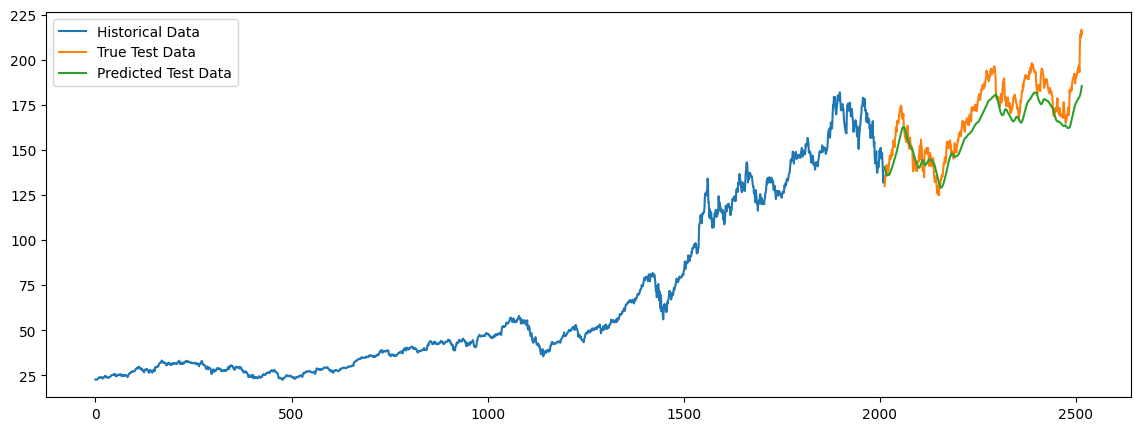

In [74]:

# 绘制结果
historical_data = data[:train_size].flatten()
test_data = data[train_size:].flatten()

plt.figure(figsize=(14, 5))
plt.plot(np.arange(len(historical_data)), historical_data, label='Historical Data')
plt.plot(np.arange(len(historical_data), len(historical_data) + len(test_data)), y_test.flatten(), label='True Test Data')
plt.plot(np.arange(len(historical_data), len(historical_data) + len(test_data)), test_predictions.flatten(), label='Predicted Test Data')
plt.legend()
plt.show()